In [2]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import geopandas as gpd
from shapely.geometry import shape, Point
import collections
from scipy.stats.mstats import zscore

# Import the list of selected images from the fringes of the
The images are saved inthe picke file as a touple of key and dictionary
a sample is here 
('50f5ed56fdc9f065f0008c3c',
 {'key': '50f5ed56fdc9f065f0008c3c',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5ed56fdc9f065f0008c3c.jpg',
  'trueSkill': [34.40761521557218]}
 )

In [48]:
#ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImages.pkl"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImagesBottomUp.pkl"
ImageList = "/datasets_1/sagarj/BellLabs/Data/bostonDf.pkl"
urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/mediumImages.pkl"
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [15]:
datasetImageCoords = "/datasets_1/sagarj/BellLabs/Data/AllStreetScoreImageLocs.pkl"

In [16]:
with open(datasetImageCoords,'rb') as f:
    imgCoords = pickle.load(file=f)

In [6]:
type(imgCoords[imgCoords.keys()[1]])

shapely.geometry.point.Point

In [670]:
imgLocDict = {}
for i in imgCoords:
    imgLocDict[i] = dict()
    imgLocDict[i]['Lat'] = imgCoords[i].y
    imgLocDict[i]['Long'] = imgCoords[i].x
    

In [671]:
# with open("allImageLocs.json", 'wb') as f:
#     json.dump(imgLocDict,f)

In [20]:
usa = gpd.read_file("../shapeFiles/cb_2016_us_ua10_500k.shp")

In [21]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [22]:
us_selected_poly = ['Boston, MA--NH--RI']
bos_poly = [usa[(usa['NAME10'] == k)]['geometry'] for k in us_selected_poly]

In [23]:
bos_poly

[1283    (POLYGON ((-70.861812 42.658277, -70.860432 42...
 Name: geometry, dtype: object]

In [24]:
bostonImages = {}
for k in imgCoords:
     if checkPoly(Point(imgCoords[k].x , imgCoords[k].y),bos_poly):
            #print "Found one"
            bostonImages[k] = imgCoords[k]

In [25]:
len(bostonImages)

1332

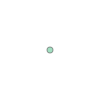

In [851]:
bostonImages[bostonImages.keys()[1]]

In [49]:
len(imgList)

127

In [30]:
len(list(set(imgList.keys()).intersection(set(bostonImages.keys()))))

127

In [211]:
ugliestImgs = {}
for k in imgList:
    if imgList[k][1]['trueSkill'][0] < 18:
        print "found"
        ugliestImgs[k] = imgList[k]

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


In [207]:
len(ugliestImgs)

0

Directory path to the list of sampled transformed images

In [32]:
#AMImages = "/datasets/sagarj/streetView/Transform_1000/"
AMImages = "/datasets/sagarj/streetView/Transform_Boston150/"
#AMImages = "/datasets/sagarj/streetView/Transform_Medium/"

In [33]:
files = os.listdir(AMImages)

In [34]:
files[1].split('_')

['513d676efdc9f03587004089', '0001', '0.451787', '.jpg']

In [35]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [36]:
len(filesMap.keys())

127

In [38]:
for row in imgList:
    if imgList[row][1]['key'] in filesMap.keys():
        filesMap[imgList[row][1]['key']]['origPath'] = imgList[row][1]['path']
        filesMap[imgList[row][1]['key']]['label'] = imgList[row][1]['label']

### The above code created a files map as seen below which makes a single data structure which has 
* transformation final activation 
* the label of the class to which the image was transformed into (1 = beauty , 0 = ugly)
* original label
* original path of the un transformed image 
* Path to the synthesized image

In [39]:
filesMap[filesMap.keys()[1]]

{'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg'}

In [40]:
#Image(filesMap['513d9f45fdc9f035870086b4']['origPath'])

In [41]:
#Image(filesMap['513d9f45fdc9f035870086b4']['path'])

In [42]:
#filesMap['513d9f45fdc9f035870086b4']['changeLabel']

### The below code is a feature extraction code that uses PlacesNet CNN to extract the last but one fully connected layer which is a 4096 dimensional vector

#### the block has 
* A code to transform the image to a consumable size 
* A block that extracts the 4096 dimensional features
* A block that actually returns the top 5 Places labels (Used for measurement)

In [43]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['path'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = transformer.preprocess('data',caffe.io.load_image(path))
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

def getPlaces(path):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    path = path.strip()
    if not os.path.exists(path):
        featArray = np.zeros((1,4096))
    else:
        im = transformer.preprocess('data',caffe.io.load_image(path))
        net.blobs['data'].data[...] = im - meanMat
        net.forward()
        featArray = net.blobs['prob'].data.copy()
    return featArray

In [44]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

### The getFeatMatrix function edits the dictionary in place and adds the features as a part of FilesMap dictionary created before

In [45]:
transformedFilesMap = getFeatMatrix(filesMap)

In [47]:
transformedFilesMap[transformedFilesMap.keys()[120]]

{'act': '0.47995',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6bc3fdc9f03587004dcc.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d6bc3fdc9f03587004dcc_0001_0.47995_.jpg',
 'placesFeats': array([[ 0.32846427,  0.        ,  0.22085756, ...,  0.44977036,
          0.74997276,  0.04764491]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [ ]:
# with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
#     imagePaths = f.readlines()

In [ ]:
# len(imagePaths)

In [ ]:
# sampledpaths = random.sample(imagePaths , 5000)

In [ ]:
# sampledpaths[1]

In [ ]:
# sampledPathsDict = {}
# for f in sampledpaths:
#     comps = f.strip().split(',')
#     lbl = comps[1]
#     imgID = comps[0].split('/')[-1].split('.')[0]
#     sampledPathsDict[imgID] = {}
#     sampledPathsDict[imgID]['origPath'] = comps[0]
#     sampledPathsDict[imgID]['label'] = lbl

In [ ]:
# sampledPathsDict[sampledPathsDict.keys()[100]]

In [ ]:
# with open("../Data/sampledSegnetImages.pkl",'wb') as f:
#     pickle.dump(sampledPathsDict,f,protocol=pickle.HIGHEST_PROTOCOL)

# sampledSegnetImages.pkl is a file used for measurement to analyse segnet zones in an image
### After saving the disctionay, you will need to run the segnet extraction script externally. Halt at this point



In [52]:
#Image dataset (Pool of images to match from) 
with open('/datasets_1/sagarj/BellLabs/Data/bostonAllSegnet.pkl', 'rb') as handle:
    testSegnetLabels = pickle.load(handle)
# with open('../Data/testSegnetFeatures.pkl', 'rb') as handle:
#     testSegnetLabels = pickle.load(handle)
#with open('../Data/retrievalSegnetLabelsTextures.pkl', 'rb') as handle:
#    segnetLabels = pickle.load(handle)

#Root images which are being transformed 
# with open('../Data/fringe1000SegnetFeatures.pkl', 'rb') as handle:
#     segnetLabels = pickle.load(handle)

with open('/datasets_1/sagarj/BellLabs/Data/bostonUglySegnet.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)


In [53]:
print len(testSegnetLabels.keys()), len(segnetLabels.keys())

774 127


In [570]:
allImagesToShare = list(set(testSegnetLabels.keys()).union(set(segnetLabels.keys())))

In [54]:
segnetLabels[segnetLabels.keys()[1]]

{'segnetLabels': array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 4.,  9.,  9., ...,  5.,  5.,  5.],
        [ 4.,  4.,  4., ...,  5.,  5.,  5.],
        [ 4.,  4.,  4., ...,  5.,  5.,  5.]], dtype=float32)}

In [66]:
with open('../Data/bostonAllFringe.pkl', 'rb') as handle:
    testImages = pickle.load(handle)

In [67]:
len(testImages)

774

In [69]:
testKeys = [testImages[i][1]['key']  for i in testImages]
transformedKeys = [k for k in filesMap]

In [70]:
len(testKeys)

774

In [71]:
common = [k for k in transformedKeys if k in testKeys]

In [72]:
len(common)

79

In [74]:
filteredTestImages = []
for k in testImages:
    if k[0] not in common:
        filteredTestImages.append(k)

In [80]:
filteredTestImages[1]

'513d67e8fdc9f035870041c2'

In [81]:
dataFileMap = {}
for p in filteredTestImages:
    path = testImages[p][1]['path']
    key = testImages[p][1]['key']
    dataFileMap[key] = {}
    dataFileMap[key]['path'] = path

In [82]:
dataFileMap[dataFileMap.keys()[1]]

{'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b62fdc9f03587004ce4.jpg'}

## Extract Places Fc6 features from Test images for further retrieval code

In [83]:
retreivalFileMap = getFeatMatrix(dataFileMap)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# End shitty zone now. the next sections are about matching

Here we find pairwise distances between transformed images and images from dataset.

In [84]:
filesMap[filesMap.keys()[1]]

{'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg',
 'placesFeats': array([[ 0.41810766,  0.11022168,  0.        , ...,  0.59241825,
          0.54558182,  0.        ]], dtype=float32)}

In [85]:
for k in filesMap:
    if k in segnetLabels:
        pixelcounts = collections.Counter(np.squeeze(segnetLabels[k]['segnetLabels']).flatten())
        filesMap[k]['segnet'] = {}
        denom = segnetLabels[k]['segnetLabels'].shape[0]*segnetLabels[k]['segnetLabels'].shape[1]
        for r in pixelcounts:
            filesMap[k]['segnet'][r] = float(pixelcounts[r])/float(denom)

        

In [86]:
for k in retreivalFileMap:
    if k in testSegnetLabels:
        pixelcounts = collections.Counter(np.squeeze(testSegnetLabels[k]['segnetLabels']).flatten())
        retreivalFileMap[k]['segnet'] = {}
        denom = testSegnetLabels[k]['segnetLabels'].shape[0]*testSegnetLabels[k]['segnetLabels'].shape[1]
        for r in pixelcounts:
            retreivalFileMap[k]['segnet'][r] = float(pixelcounts[r])/float(denom)


In [87]:
print len(filesMap.keys()), len(retreivalFileMap.keys())

127 774


In [565]:
len(set(filesMap.keys()).intersection(set(retreivalFileMap.keys())))

79

In [839]:
def lockDownDistanceFunction(src, dst):
    labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
    #features to lock
    lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but trees
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0 ] #Everything but Mobility
    #lockDownRatios = [ 0.0 , 1.0 , 3.0 , 4.0 , 6.0, 9.0 , 10.0 , 11.0 ] #Everything but ROAD SIDES
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 5.0 , 6.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Roads
    #lockDownRatios = [ 0.0 , 2.0 , 3.0 , 4.0 , 5.0 ,6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Buildings
    #lockDownRatios = [ 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Sky
    #lockDownRatios = [] # Everything unlocked
    ##Tolerance levels in normalized ratios
    tol = 0.1
    for obj in lockDownRatios:
        if obj in src['segnet']:
            if obj not in dst['segnet']:
                return float('inf')
            if dst['segnet'][obj] > (src['segnet'][obj]+tol) or dst['segnet'][obj] < (src['segnet'][obj]-tol) :
                return float('inf')
    return distance.euclidean(dst['placesFeats'] , src['placesFeats'])
    

In [840]:
from scipy.spatial import distance
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        #distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        #distanceMapper[k][i] = distance.euclidean(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        
        ##This distance function locks down feature areas in an image
        distanceMapper[k][i] = lockDownDistanceFunction(filesMap[k] , retreivalFileMap[i])

In [829]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [718]:
AllFilesDict = merge_two_dicts(filesMap.copy() , retreivalFileMap.copy())
len(AllFilesDict)

822

In [703]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]

In [642]:
# mapper = {'W':'Walkable' , 'L' : 'Landmark' , 'A' : 'Architectural' , 'N' : 'Natural' }
# for k in AllFilesDict:
#     print "processing : " + k
#     arr = getPlaces(AllFilesDict[k]['path'])
#     probs = np.squeeze(arr)
#     topArgs = probs.argsort()[-5:][::-1]
#     labelList = []
#     TnomyCount = {'Walkable' : 0 , 'Landmark': 0 , 'Architectural' : 0 , 'Natural' : 0}
#     for i in topArgs:
#         key = str(i)
#         if catDict[key]['tnomy'] != '':
#             tnomy = catDict[key]['tnomy']
#             TnomyCount[mapper[tnomy]]+=1
#         labelList.append(catDict[key]['label'])
#     AllFilesDict[k]['Top5PlaceLabels'] = labelList
#     AllFilesDict[k]['TnomyScores'] = dict()
#     AllFilesDict[k]['TnomyScores'] = TnomyCount
    
            

processing : 513d67e8fdc9f035870041c2
processing : 513d6b62fdc9f03587004ce4
processing : 513d6a1ffdc9f03587004978
processing : 513d6a72fdc9f03587004a7f
processing : 513d6ad3fdc9f03587004b7e
processing : 513d67e2fdc9f035870041b3
processing : 513d6c86fdc9f03587004fb6
processing : 513d6ca3fdc9f03587005004
processing : 513d6c47fdc9f03587004f1e
processing : 513d6911fdc9f035870045c9
processing : 513d6b2efdc9f03587004c6d
processing : 513d676efdc9f03587004089
processing : 513d6927fdc9f03587004622
processing : 513d6c2ffdc9f03587004ee2
processing : 513d69b8fdc9f0358700481f
processing : 513d687afdc9f035870043ad
processing : 513d6b99fdc9f03587004d6c
processing : 513d69a8fdc9f035870047e9
processing : 513d6833fdc9f035870042b1
processing : 513d6a46fdc9f035870049ff
processing : 513d6975fdc9f03587004730
processing : 513d6bc5fdc9f03587004dd1
processing : 513d6a44fdc9f035870049f7
processing : 513d687cfdc9f035870043b6
processing : 513d6ae8fdc9f03587004bb5
processing : 513d6a6efdc9f03587004a76
processing :

processing : 513d6a8efdc9f03587004ac8
processing : 513d67bafdc9f03587004150
processing : 513d6a9bfdc9f03587004ae9
processing : 513d6b03fdc9f03587004bfa
processing : 513d6923fdc9f03587004613
processing : 513d6886fdc9f035870043de
processing : 513d6923fdc9f03587004610
processing : 513d696dfdc9f0358700470e
processing : 513d6c6efdc9f03587004f7f
processing : 513d6b1efdc9f03587004c44
processing : 513d6be0fdc9f03587004e1b
processing : 513d6b00fdc9f03587004bf1
processing : 513d6879fdc9f035870043aa
processing : 513d6b80fdc9f03587004d2d
processing : 513d6accfdc9f03587004b6d
processing : 513d6896fdc9f0358700440e
processing : 513d6b5cfdc9f03587004cd5
processing : 513d6a61fdc9f03587004a55
processing : 513d6959fdc9f035870046c7
processing : 513d678efdc9f035870040e3
processing : 513d6841fdc9f035870042ea
processing : 513d6b16fdc9f03587004c31
processing : 513d6817fdc9f03587004253
processing : 513d677efdc9f035870040b5
processing : 513d6817fdc9f03587004255
processing : 513d6b7cfdc9f03587004d23
processing :

processing : 513d6b25fdc9f03587004c52
processing : 513d6951fdc9f035870046a8
processing : 513d6bf9fdc9f03587004e58
processing : 513d684afdc9f03587004306
processing : 513d6b1ffdc9f03587004c46
processing : 513d6ae4fdc9f03587004bab
processing : 513d6c62fdc9f03587004f61
processing : 513d6989fdc9f0358700477a
processing : 513d6b1ffdc9f03587004c48
processing : 513d6bddfdc9f03587004e11
processing : 513d69c6fdc9f0358700484d
processing : 513d6aa9fdc9f03587004b10
processing : 513d6984fdc9f03587004768
processing : 513d69c6fdc9f0358700484c
processing : 513d6b73fdc9f03587004d0d
processing : 513d6a86fdc9f03587004ab1
processing : 513d6779fdc9f035870040a7
processing : 513d6a59fdc9f03587004a3c
processing : 513d68fffdc9f03587004587
processing : 513d6af3fdc9f03587004bd3
processing : 513d6851fdc9f03587004321
processing : 513d67c4fdc9f03587004167
processing : 513d6b14fdc9f03587004c2d
processing : 513d68d8fdc9f035870044fc
processing : 513d6b14fdc9f03587004c2b
processing : 513d676ffdc9f0358700408c
processing :

In [645]:
# AllFilesDictBkp = AllFilesDict.copy()

In [664]:
# finalScoreDict = {}
# for k in AllFilesDict:
#     finalScoreDict[k] = dict()
#     labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
#     skyscore = 0
#     greenscore = 0
#     if 0.0 in AllFilesDict[k]['segnet']:
#         if AllFilesDict[k]['segnet'][0.0] > 0.0 and AllFilesDict[k]['segnet'][0.0] <= 0.1:
#             skyscore = 1
#         elif AllFilesDict[k]['segnet'][0.0] > 0.1 and AllFilesDict[k]['segnet'][0.0] <= 0.2:
#             skyscore = 2
#         elif AllFilesDict[k]['segnet'][0.0] > 0.2 and AllFilesDict[k]['segnet'][0.0] <= 0.3:
#             skyscore = 3
#         elif AllFilesDict[k]['segnet'][0.0] > 0.3 and AllFilesDict[k]['segnet'][0.0] <= 0.4: 
#             skyscore = 4
#         else:
#             skyscore = 5
    
#     if 6.0 in AllFilesDict[k]['segnet']:
#         if AllFilesDict[k]['segnet'][6.0] > 0.0 and AllFilesDict[k]['segnet'][6.0] <= 0.1:
#             greenscore = 1
#         elif AllFilesDict[k]['segnet'][6.0] > 0.1 and AllFilesDict[k]['segnet'][6.0] <= 0.2:
#             greenscore = 2
#         elif AllFilesDict[k]['segnet'][6.0] > 0.2 and AllFilesDict[k]['segnet'][6.0] <= 0.3:
#             greenscore = 3
#         elif AllFilesDict[k]['segnet'][6.0] > 0.3 and AllFilesDict[k]['segnet'][6.0] <= 0.4: 
#             greenscore = 4
#         else:
#             greenscore = 5
    
#     finalScoreDict[k]['Openness'] = skyscore
#     finalScoreDict[k]['GreenCover'] = greenscore
#     finalScoreDict[k]['Top5PlaceLabels'] = AllFilesDict[k]['Top5PlaceLabels']
#     finalScoreDict[k]['TnomyScores'] = AllFilesDict[k]['TnomyScores']
#     finalScoreDict[k]['segnet'] = dict()
#     for l in AllFilesDict[k]['segnet'] :
#         finalScoreDict[k]['segnet'][labels[int(l)]] = AllFilesDict[k]['segnet'][l]
    
    

In [666]:
finalScoreDict[finalScoreDict.keys()[10]]

{'GreenCover': 4,
 'Openness': 1,
 'TnomyScores': {'Architectural': 4,
  'Landmark': 0,
  'Natural': 0,
  'Walkable': 1},
 'Top5PlaceLabels': ['/r/residential_neighborhood',
  '/a/alley',
  '/h/highway',
  '/d/driveway',
  '/a/apartment_building/outdoor'],
 'segnet': {'Building': 0.2206423611111111,
  'Fence': 0.0015972222222222223,
  'Pavement': 0.06767361111111111,
  'Pedestrian': 0.001105324074074074,
  'Pole': 0.014953703703703703,
  'Road': 0.16626736111111112,
  'Road Marking': 0.004774305555555556,
  'Sign Symbol': 5.787037037037037e-05,
  'Sky': 0.035549768518518515,
  'Tree': 0.3849826388888889,
  'Vehicle': 0.10239583333333334}}

In [667]:
# import json
# with open('bostonScores.json', 'w') as fp:
#     json.dump(finalScoreDict, fp)

In [525]:
#distanceMapper[distanceMapper.keys()[0]]

### Create a dictionary to store the final matching results with original and top 5 matches

In [841]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [842]:
top5s[top5s.keys()[1]]

[('513d67d2fdc9f0358700418b', 27.617597579956055),
 ('513d6c9dfdc9f03587004ff1', 28.07564353942871),
 ('513d68ccfdc9f035870044d7', 28.148910522460938),
 ('513d6771fdc9f03587004092', 28.299213409423828),
 ('513d6b88fdc9f03587004d3e', 28.676267623901367)]

In [843]:
# index = pd.Series(range(len(filesMap.keys())))
# column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [844]:
len(filesMap)

127

In [845]:
filesMap[filesMap.keys()[1]]

{'GreenCover': 4,
 'Openness': 2,
 'TnomyScores': {'Architectural': 0,
  'Landmark': 0,
  'Natural': 0,
  'Walkable': 4},
 'Top5PlaceLabels': ['/p/patio',
  '/a/alley',
  '/c/courtyard',
  '/c/cottage_garden',
  '/l/lobby'],
 'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg',
 'placesFeats': array([[ 0.41810766,  0.11022168,  0.        , ...,  0.59241825,
          0.54558182,  0.        ]], dtype=float32),
 'segnet': {0.0: 0.12306134259259259,
  1.0: 0.12664930555555556,
  2.0: 0.008344907407407407,
  3.0: 0.0018171296296296297,
  4.0: 0.20444444444444446,
  5.0: 0.0842650462962963,
  6.0: 0.36342592592592593,
  7.0: 0.00024305555555555555,
  8.0: 0.0031944444444444446,
  9.0: 0.08447916666666666,
  11.0: 7.523148148148149e-05}}

In [846]:
retreivedDf = {}

In [847]:
imgCoords[filesMap.keys()[1]].xy

(array('d', [-71.01274000000002]), array('d', [42.406936]))

In [848]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5locs = {}
    for l in top5s[k]:
        top5locs[l[0]] = {}
        top5locs[l[0]]['long'] = imgCoords[l[0]].x
        top5locs[l[0]]['lat'] = imgCoords[l[0]].y
    top5Paths = [dataFileMap[p[0]]['path'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    originLoc = {'long' : imgCoords[k].x , 'lat' : imgCoords[k].y}
    retreivedDf[k] = dict()
    retreivedDf[k] = {'key' : k , 'originLoc' : originLoc, 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths] , 'Top5Locs' : top5locs}

In [849]:
# import json
# bestDict = {}
# for k in retreivedDf:
#     bestDict[k] = retreivedDf[k]
# with open('bostonResultsAll/EverythingLockedboston.json', 'w') as fp:
#     json.dump(bestDict, fp)

#### Example of a the retrieved datastructure

In [762]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['513d6781fdc9f035870040bf',
   '513d6b7cfdc9f03587004d23',
   '513d67d2fdc9f0358700418b',
   '513d6c9dfdc9f03587004ff1',
   '513d68ccfdc9f035870044d7']],
 'Top5Locs': {'513d6781fdc9f035870040bf': {'lat': 42.306672,
   'long': -71.12599699999998},
  '513d67d2fdc9f0358700418b': {'lat': 42.313072, 'long': -71.09282400000002},
  '513d68ccfdc9f035870044d7': {'lat': 42.311218, 'long': -71.12872400000003},
  '513d6b7cfdc9f03587004d23': {'lat': 42.410808, 'long': -71.137429},
  '513d6c9dfdc9f03587004ff1': {'lat': 42.338113, 'long': -71.13611999999999}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/513d6781fdc9f035870040bf.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b7cfdc9f03587004d23.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d67d2fdc9f0358700418b.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c9dfdc9f03587004ff1.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d68ccfdc9f035870044d7.jpg']],
 'XformP

In [763]:
retreivedDf[retreivedDf.keys()[10]]['Top5Paths'][0]

['/work/sagarj/Work/BellLabs/streetview/PPImages/513d67a4fdc9f0358700411a.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6817fdc9f03587004253.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d697cfdc9f03587004750.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6bb6fdc9f03587004db0.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6bd6fdc9f03587004dfe.jpg']

In [764]:
len(retreivedDf)

127

## Test the retrieved images

In [765]:
# for k in range(len(retreivedDf.keys()[:90])):
#     print retreivedDf[retreivedDf.keys()[k]]['XformPath']

In [766]:
bestExamples = [k for k in retreivedDf if k in ugliestImgs.keys()]

In [767]:
# k = #158 #59 #934 #831 #904 #113 #112 #56 #58 #196 #193 #31 #30 #111 #24 #111 #16 #190 16 #15 #114 #54 #40 #42 #85

In [768]:
k = bestExamples[1]

In [592]:
retreivedDf[k]

{'Top5Keys': [['513d6a29fdc9f0358700499b',
   '513d68f8fdc9f0358700456f',
   '513d6b8dfdc9f03587004d4d',
   '513d6811fdc9f0358700423f',
   '513d6c63fdc9f03587004f65']],
 'Top5Locs': {'513d6811fdc9f0358700423f': {'lat': 42.378912,
   'long': -71.13548300000002},
  '513d68f8fdc9f0358700456f': {'lat': 42.329407, 'long': -71.15610600000002},
  '513d6a29fdc9f0358700499b': {'lat': 42.332741, 'long': -71.14960400000002},
  '513d6b8dfdc9f03587004d4d': {'lat': 42.34169, 'long': -71.137067},
  '513d6c63fdc9f03587004f65': {'lat': 42.391402, 'long': -71.16295200000002}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/513d6a29fdc9f0358700499b.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d68f8fdc9f0358700456f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b8dfdc9f03587004d4d.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6811fdc9f0358700423f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c63fdc9f03587004f65.jpg']],
 'XformPa

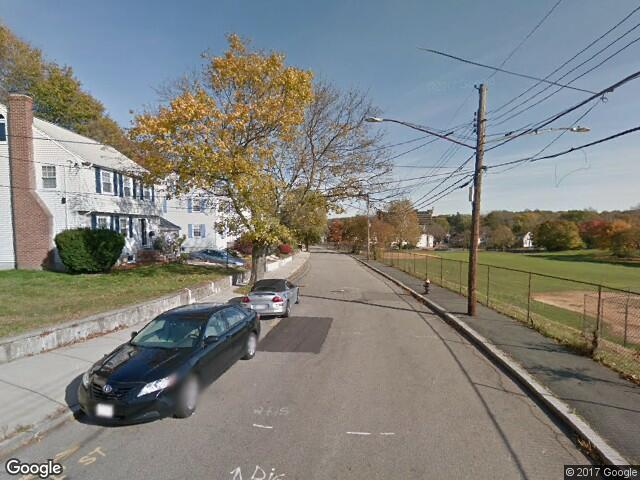

In [593]:
Image(retreivedDf[k]['origPath'])

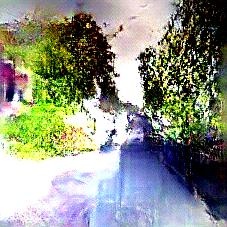

In [594]:
Image(retreivedDf[k]['XformPath'])

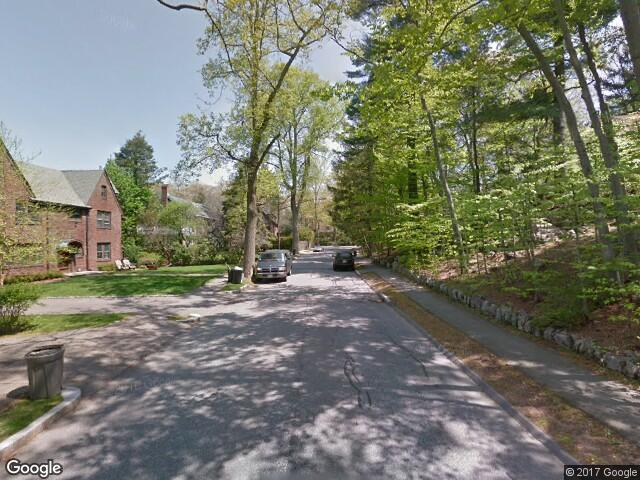

In [595]:
Image(retreivedDf[k]['Top5Paths'][0] [1])

In [596]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['513d6b8dfdc9f03587004d4d',
   '513d6951fdc9f035870046a8',
   '513d68f8fdc9f0358700456f',
   '513d6811fdc9f0358700423f',
   '513d6a29fdc9f0358700499b']],
 'Top5Locs': {'513d6811fdc9f0358700423f': {'lat': 42.378912,
   'long': -71.13548300000002},
  '513d68f8fdc9f0358700456f': {'lat': 42.329407, 'long': -71.15610600000002},
  '513d6951fdc9f035870046a8': {'lat': 42.304532, 'long': -71.131689},
  '513d6a29fdc9f0358700499b': {'lat': 42.332741, 'long': -71.14960400000002},
  '513d6b8dfdc9f03587004d4d': {'lat': 42.34169, 'long': -71.137067}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b8dfdc9f03587004d4d.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6951fdc9f035870046a8.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d68f8fdc9f0358700456f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6811fdc9f0358700423f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6a29fdc9f0358700499b.jpg']],
 'XformPath': '/d

In [597]:
from shutil import copyfile
import csv

In [598]:
#Sample images for mturk experiment

# mturkDir = "/work/sagarj/Work/work_ipython/BellLabs/Data/Mturk/"
# urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/Mturk/"
# original = "Grp1/"
# Xformed = "Grp2/"
# batchSize = 200
# start = 0
# saveDict = {}
# turk = open(mturkDir + "csvMturk.csv" , 'wb')
# csvWriter = csv.writer(turk, delimiter=',')
# csvWriter.writerow(['image_A_url' ,'image_B_url'])
# for k in retreivedDf:
#     label = retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1]
#     saveDict[k] = label
#     srcFile = k+'_o.jpg'
#     destFile = k+'_x.jpg'
#     copyfile(retreivedDf[k]['origPath'] , mturkDir + original + srcFile)
#     copyfile(retreivedDf[k]['Top5Paths'][0][0] , mturkDir + Xformed + destFile)
#     csvWriter.writerow([urlPrepend + original + srcFile , urlPrepend + Xformed + destFile])
#     start+=1
#     if start >= batchSize:
#         break
# turk.close()

# with open("../Data/mturkPilotLabels.pkl",'wb') as f:
#     pickle.dump(saveDict , f , protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
    



In [599]:
with open("../Data/mturkPilotLabels.pkl",'rb') as f:
    saveDict = pickle.load(f)

In [600]:
# with open("../Data/retreivedfringeDataframe2.pkl" , 'wb') as f:
#     pickle.dump(retreivedDf , f , protocol=pickle.HIGHEST_PROTOCOL)

In [601]:
mturkResults = "../Data/mturk_pilot2.csv"
results = pd.read_csv(mturkResults)


In [602]:
grouped = results.groupby('HITId')
votes = {}
for k in grouped.groups.keys():
    votes[k] = grouped.get_group(k)

In [603]:
#results.head()

### calculate agreement with humans regarding agreement

In [604]:
beautyAgree = 0
beautyDisagree = 0
uglyAgree = 0
uglyDisagree = 0
totalb = 0
totalu = 0
#confuse = 0
for k in votes:
    a  = sum(votes[k]['Answer.choice'] == 'optionB')
    key = votes[k]['Input.image_A_url'].iloc[0].split('/')[-1].split('_')[0]
    if key in saveDict:
        if saveDict[key]=='1':
            totalb+=1
            if a >= 2: 
                beautyAgree+=1
            else:
                beautyDisagree+=1
        else:
            totalu+=1
            if a < 2:
                uglyAgree+=1
            else:
                uglyDisagree+=1
                
            
        

In [605]:
print float((beautyAgree + uglyAgree))/200 , float(beautyAgree)/totalb , float(uglyAgree)/totalu

0.765 0.690909090909 0.855555555556


# After this step, run the segnet code to extract the right labeled pixel info

In [606]:
len(segnetLabels.keys()) , len(testSegnetLabels.keys())

(127, 774)

In [607]:
collections.Counter(np.squeeze(testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels']).flatten())

Counter({0.0: 22584,
         1.0: 73262,
         2.0: 1608,
         3.0: 1955,
         4.0: 37063,
         5.0: 3035,
         6.0: 2455,
         7.0: 314,
         8.0: 86,
         9.0: 29425,
         10.0: 992,
         11.0: 21})

In [608]:
segnetLabels[segnetLabels.keys()[10]]['segnetLabels'].shape

(360, 480)

In [609]:
testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels'].shape

(360, 480)

In [610]:
retreivedDf[retreivedDf.keys()[101]]['Top5Keys'][0]

['513d67affdc9f03587004136',
 '513d68ccfdc9f035870044d7',
 '513d6a29fdc9f0358700499b',
 '513d6b8dfdc9f03587004d4d',
 '513d688ffdc9f035870043f9']

# This section is for calculating normalized ratios of the segnet labels

In [611]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[retreivedDf[k]['key']] = {}
    deltas[retreivedDf[k]['key']]['act'] = xformact
    deltas[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['top5'] = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:  
            if l in testSegnetLabels.keys():
                deltas[retreivedDf[k]['key']]['top5'].append(normalizeDict(collections.Counter(np.squeeze(testSegnetLabels[l]['segnetLabels'].flatten())) , denom))
                
    
    
    
    
    

In [612]:
deltas[deltas.keys()[1]]

{'act': 0.480963,
 'label': 1,
 'origLabels': {0.0: 0.12306134259259259,
  1.0: 0.12664930555555556,
  2.0: 0.008344907407407407,
  3.0: 0.0018171296296296297,
  4.0: 0.20444444444444446,
  5.0: 0.0842650462962963,
  6.0: 0.36342592592592593,
  7.0: 0.00024305555555555555,
  8.0: 0.0031944444444444446,
  9.0: 0.08447916666666666,
  11.0: 7.523148148148149e-05},
 'top5': [{0.0: 0.027991898148148148,
   1.0: 0.11730902777777778,
   2.0: 0.0020486111111111113,
   4.0: 0.007094907407407407,
   5.0: 0.1274537037037037,
   6.0: 0.6871701388888889,
   7.0: 0.00016203703703703703,
   8.0: 0.026585648148148146,
   9.0: 0.0028877314814814816,
   11.0: 0.0012962962962962963},
  {0.0: 0.09973958333333334,
   1.0: 0.035561342592592596,
   2.0: 0.004149305555555555,
   3.0: 0.0002719907407407407,
   4.0: 0.1777372685185185,
   5.0: 0.13186921296296297,
   6.0: 0.516712962962963,
   8.0: 0.003292824074074074,
   9.0: 0.030520833333333334,
   10.0: 0.00014467592592592592},
  {0.0: 0.1199537037037037,


In [613]:
# with open("SegnetDictionary.pkl" , 'wb') as f:
#     pickle.dump(deltas , f , protocol=pickle.HIGHEST_PROTOCOL)

In [614]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [615]:
# deltas[deltas.keys()[100]]['top5']
mean = {}
std = {}

scores = {}
beautfiedScores = {}
uglifiedScores = {}
origScores = {}
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            if dim not in scores:
                
                origScores[dim] = []
                beautfiedScores[dim] = []
                uglifiedScores[dim] = []
                scores[dim] = []
            scores[dim].append(ratios[dim])
            
            #Find change in scores and the score 
            orig_score = 0.0
            if dim in deltas[k]['origLabels']:
                orig_score = deltas[k]['origLabels'][dim]
            origScores[dim].append(orig_score)
            if deltas[k]['label'] == 1:
                beautfiedScores[dim].append(ratios[dim] - orig_score)
            else:
                uglifiedScores[dim].append(ratios[dim] - orig_score)
#print scores.keys()
for k in origScores:
    mean[k] = np.mean(origScores[k])
    std[k] = np.std(origScores[k])
    
print mean , std

{0.0: 0.2592691017789443, 1.0: 0.16522153071256676, 2.0: 0.012603244756980957, 3.0: 0.0094863659531090726, 4.0: 0.21206496974336539, 5.0: 0.080386045494313205, 6.0: 0.16399323782443861, 7.0: 0.0014612787535293139, 8.0: 0.036526709822993338, 9.0: 0.055765666010498684, 10.0: 0.002733089912978881, 11.0: 0.0011866865773115772} {0.0: 0.14254228826936968, 1.0: 0.1504904699086107, 2.0: 0.010593226682414058, 3.0: 0.012055454248297428, 4.0: 0.09268925238605448, 5.0: 0.060733377363984507, 6.0: 0.13684465084864686, 7.0: 0.0039039797132018753, 8.0: 0.039446022788553761, 9.0: 0.064005114690081299, 10.0: 0.005943976642287946, 11.0: 0.0031175127351030598}


In [616]:
#calculate change in object value in terms of Zscore in original population


beautfiedZscores = {}
uglifiedZscores = {}
for k in beautfiedScores:
    if k not in beautfiedZscores:
        beautfiedZscores[k] = []
        
    for val in beautfiedScores[k]:
        orig = beautfiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        beautfiedZscores[k].append(Zscore)


for k in uglifiedScores:
    if k not in uglifiedZscores:
        uglifiedZscores[k] = []
        
    for val in uglifiedScores[k]:
        orig = uglifiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        uglifiedZscores[k].append(Zscore)

In [617]:
#beautfiedScores[1]

### Plot deltas between original and transformed (measurement)

In [618]:
dim = 6

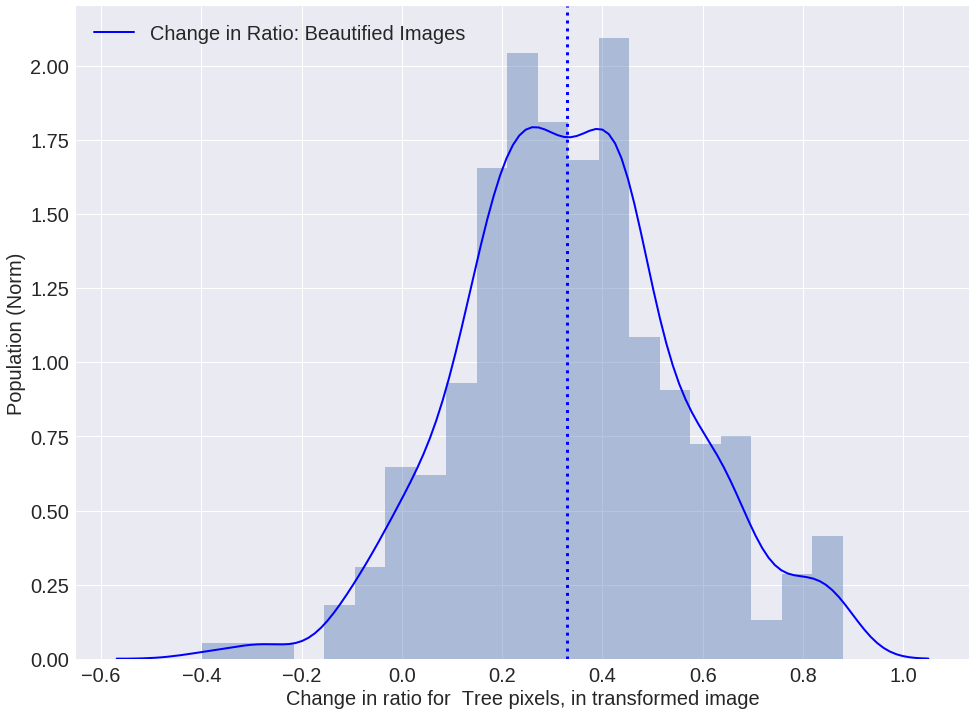

In [619]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautfiedScores[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Change in Ratio: Beautified Images"})
#sns.distplot(uglifiedScores[dim] , kde_kws={"color": "g", "lw": 2, "label": "Change in Ratio: Uglified Images"})
ax.axvline(x=np.median(beautfiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglifiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Change in ratio for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [620]:
deltas[deltas.keys()[1]]

{'act': 0.480963,
 'label': 1,
 'origLabels': {0.0: 0.12306134259259259,
  1.0: 0.12664930555555556,
  2.0: 0.008344907407407407,
  3.0: 0.0018171296296296297,
  4.0: 0.20444444444444446,
  5.0: 0.0842650462962963,
  6.0: 0.36342592592592593,
  7.0: 0.00024305555555555555,
  8.0: 0.0031944444444444446,
  9.0: 0.08447916666666666,
  11.0: 7.523148148148149e-05},
 'top5': [{0.0: 0.027991898148148148,
   1.0: 0.11730902777777778,
   2.0: 0.0020486111111111113,
   4.0: 0.007094907407407407,
   5.0: 0.1274537037037037,
   6.0: 0.6871701388888889,
   7.0: 0.00016203703703703703,
   8.0: 0.026585648148148146,
   9.0: 0.0028877314814814816,
   11.0: 0.0012962962962962963},
  {0.0: 0.09973958333333334,
   1.0: 0.035561342592592596,
   2.0: 0.004149305555555555,
   3.0: 0.0002719907407407407,
   4.0: 0.1777372685185185,
   5.0: 0.13186921296296297,
   6.0: 0.516712962962963,
   8.0: 0.003292824074074074,
   9.0: 0.030520833333333334,
   10.0: 0.00014467592592592592},
  {0.0: 0.1199537037037037,


In [621]:
dim = 1.0

In [622]:
labels = []
vectors = []
dims = [0.0 , 1.0 ]
sky = []
for k in deltas:
    for ratios in deltas[k]['top5']:
        vec = []
        for j in dims:
            compound = 1.0
            if j in ratios:
                if j in deltas[k]['origLabels']:
                    vec.append(ratios[j]-deltas[k]['origLabels'][j])
                else:
                    vec.append(ratios[j])
                
            else:
                vec.append(0.0)
        for val in vec:
            compound = compound * val
        vec.append(compound)
        if dim in ratios:
            if dim in deltas[k]['origLabels']:
                sky.append(ratios[dim]-deltas[k]['origLabels'][dim])
            else:
                sky.append(ratios[dim])
            #sky.append(ratios[0.0]/ratios[6.0])
        else:
            sky.append(0.0)
        labels.append(deltas[k]['label'])
        vectors.append(vec)
        

In [623]:
#deltas[deltas.keys()[1]]

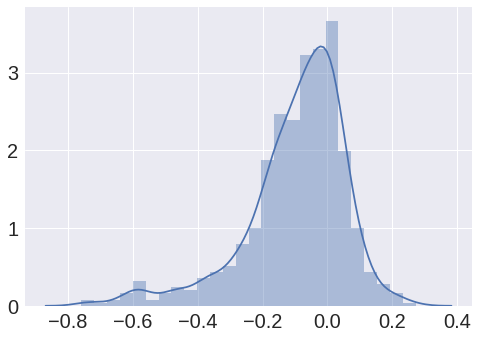

In [624]:

sns.distplot(sky)

# All the code after this is for measurement and explainability aspect of the deep network

# Binned Plot 

In [625]:
bins = {}
for i in range(6):
    bins[i] = {}
    bins[i]['label'] = []
    bins[i]['beauty'] = []
    bins[i]['ugly'] = []

#this bit is for finding sky trends in an absolute sense.

# for k in range(len(sky)):
#     if sky[k] <= 0.07 :
#         bins[0]['label'].append(labels[k])
#     elif sky[k] > 0.07 and sky[k] <= 0.14:
#         bins[1]['label'].append(labels[k])
#     elif sky[k] >0.14 and sky[k] <= 0.21:
#         bins[2]['label'].append(labels[k])
#     elif sky[k] >  0.21 and sky[k] <= 0.28:
#         bins[3]['label'].append(labels[k])
#     elif sky[k] > 0.28 and sky[k] <= 0.35 :
#         bins[4]['label'].append(labels[k])
#     elif sky[k] > 0.35 :
#         bins[5]['label'].append(labels[k])

#This bit is to find binned plot for Sky Delta

for k in range(len(sky)):
    if sky[k] <= -0.3 :
        bins[0]['label'].append(labels[k])
    elif sky[k] > -0.3 and sky[k] <= -0.1:
        bins[1]['label'].append(labels[k])
    elif sky[k] >-0.1 and sky[k] <= 0.1:
        bins[2]['label'].append(labels[k])
    elif sky[k] > 0.1 and sky[k] <= 0.3:
        bins[3]['label'].append(labels[k])
#     elif sky[k] > 0.3 and sky[k] <= 0.5 :
#         bins[4]['label'].append(labels[k])
    elif sky[k] > 0.3 :
        bins[4]['label'].append(labels[k])
    
iters = 100 
sampleSize = 5
for i in range(iters):
    for k in bins:
#         sample = random.sample(bins[k]['label'] , sampleSize)
#         bins[k]['beauty'].append(sum(sample))
        bins[k]['beauty'].append(sum(bins[k]['label']))
#         bins[k]['ugly'].append(len(sample) - sum(sample))

(array([ -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.]),
 <a list of 10 Text yticklabel objects>)

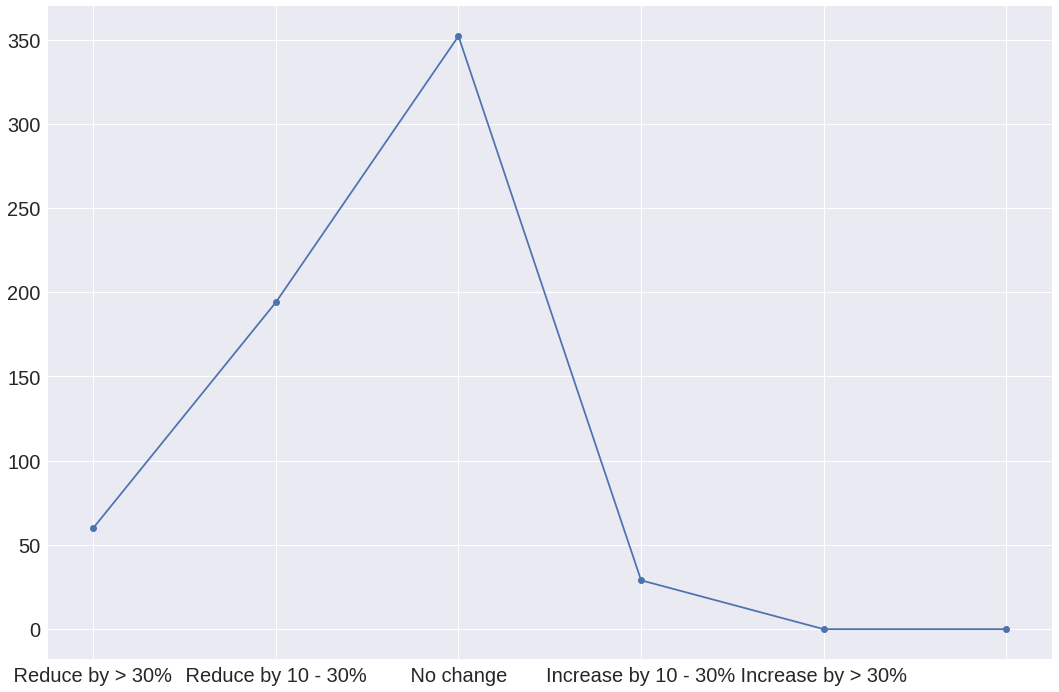

In [626]:
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
errorBeauty = [np.std(bins[i]['beauty']) for i in bins]
ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['beauty']) for i in bins], yerr=errorBeauty, fmt='-o')
# plt.plot([np.median(bins[i]['ugly']) for i in bins])
#errorUgly = [np.std(bins[i]['ugly']) for i in bins]
#ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['ugly']) for i in bins], yerr=errorUgly, fmt='-o')
#plt.xlabel(" Changes in Sky pixels " , fontsize = 20)
#plt.ylabel("Percentage of images belonging to a bin" , fontsize = 20 )

#ticks = [' Less Sky ' , ' ' , '' , '', ' More Sky ' ]
# ticks = [' Reduce by > 30% ' , ' Reduce by 10 - 30% ' , ' No change ' , 'Increase by 10 - 30%', ' Increase by > 30% ' ]
ticks = [' Reduce by > 30% ' , ' Reduce by 10 - 30% ' , ' No change ' , 'Increase by 10 - 30%', ' Increase by > 30% ' ]
plt.xticks(range(len(bins)) , ticks , fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['Beautiful Images','Ugly Images'])

In [627]:
vectors[:10]

[[0.002048611111111112, -0.35574652777777777, -0.0007287862895447534],
 [0.08419560185185185, -0.25418402777777777, -0.021401177199877826],
 [-0.08720486111111111, -0.3085532407407407, 0.026907342504179525],
 [-0.08237268518518519, -0.36797453703703703, 0.03031105069551612],
 [-0.021724537037037042, -0.38207754629629626, 0.008300457805534123],
 [-0.09506944444444444, -0.00934027777777778, 0.0008879750192901237],
 [-0.02332175925925925, -0.09108796296296297, 0.0021243315436385453],
 [-0.003107638888888889, -0.09104166666666667, 0.00028292462384259265],
 [-0.12305555555555556, -0.11074074074074075, 0.013627263374485598],
 [-0.09023726851851852, -0.06876157407407407, 0.006204856623478223]]

In [628]:
X = 100*np.asarray(vectors)
X.shape

(635, 3)

In [629]:
X[:10]

array([[  2.04861111e-01,  -3.55746528e+01,  -7.28786290e-02],
       [  8.41956019e+00,  -2.54184028e+01,  -2.14011772e+00],
       [ -8.72048611e+00,  -3.08553241e+01,   2.69073425e+00],
       [ -8.23726852e+00,  -3.67974537e+01,   3.03110507e+00],
       [ -2.17245370e+00,  -3.82077546e+01,   8.30045781e-01],
       [ -9.50694444e+00,  -9.34027778e-01,   8.87975019e-02],
       [ -2.33217593e+00,  -9.10879630e+00,   2.12433154e-01],
       [ -3.10763889e-01,  -9.10416667e+00,   2.82924624e-02],
       [ -1.23055556e+01,  -1.10740741e+01,   1.36272634e+00],
       [ -9.02372685e+00,  -6.87615741e+00,   6.20485662e-01]])

In [630]:
len(labels), len(vectors)

(635, 635)

In [633]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import r2_score , precision_score
# clf = LogisticRegression(fit_intercept=True, n_jobs=1)
# model = clf.fit(X, labels)
# #model.score()

In [634]:
# clf.predict(X)

In [ ]:
model.coef_

In [ ]:
predicted = model.predict(X)

In [ ]:
1 - model.score(X , labels)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model , X , labels , scoring='r2' )

In [ ]:
precision_score(predicted,labels)

In [ ]:
r2_score(predicted , labels)

In [ ]:
# import seaborn as sns
# fig, ax = plt.subplots()
# fig.set_size_inches(14, 8)
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (20, 14)})
# sns.set(font_scale=1.5) 
# ax = sns.barplot(x=labels, y=np.concatenate((plotablesUgly,plotablesBeauty) , axis = 0))
# ax.set(xlabel='Segnet Objects inpainted', ylabel='Percentage Reduction (Recalls in Classifier\'s Beauty prediction')

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(beautfiedScores[dim] , uglifiedScores[dim])

In [ ]:
from numpy import  std, mean, sqrt
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [ ]:
cohen_d(beautfiedScores[dim] , uglifiedScores[dim])

In [ ]:
# Find update Z scores in deltas:
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            orig = ratios[dim]
            Zscore = (orig - mean[dim])/std[dim]
            ratios[dim] = Zscore

In [ ]:
deltas[deltas.keys()[1]]

In [ ]:
## Get label wise dimensions for uglified and beautified images (top 1 image)

acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]

for k in deltas:
    #if deltas[k]['act'] > 0.1:
    #for c in deltas[k]['top5']:
    if len(deltas[k]['top5']) > 0:
        c = deltas[k]['top5'][0]
        action.append(deltas[k]['label'])
        acts.append(deltas[k]['act'])
        for dims in range(len(labels)):
            delta = 0.0
            if dims in c:
                delta = c[dims]
            labelDeltas[int(dims)].append(delta)

In [ ]:
labelDeltas[0]

In [ ]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [ ]:
dim = 9

In [ ]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]

colors = [colorPallet[action[i]] for i in range(len(action)) if labelDeltas[dim][i] != 0.0 ]
delRatio = [labelDeltas[dim][i] for i in range(len(labelDeltas[dim])) if labelDeltas[dim][i] != 0.0]
delActs = [acts[i] for i in range(len(acts)) if labelDeltas[dim][i] != 0.0 ]
print len(delRatio) , len(delActs) , len(colors)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( delRatio , delActs,  alpha=0.8 , c = colors)
#plt.legend(['Uglified' , 'Beautified'])
plt.show()

In [ ]:
len(labelDeltas[0])

Extract Beauty and ugly scores for each image based on action (uglified or beautified

In [ ]:
beautyDim = []


for j in range(len(labels)):
    beautyDim.append([labelDeltas[j][i] for i in range(len(action)) if (action[i]==1 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==1 ])

In [ ]:
uglyDim = []

for j in range(len(labels)):
    uglyDim.append([labelDeltas[j][i] for i in range(len(action)) if(action[i]==0 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==0 ])

In [ ]:
print len(beautyDim[11])

In [ ]:
print labels

In [ ]:
dim = 1

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyDim[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyDim[dim] , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [ ]:
retreivedDf[retreivedDf.keys()[1]]

In [ ]:
# beautifiedPlaces = []
# #beautyOrig = []
# uglifiedPlaces = []
# #uglyOrig = []c

# c1 = 0
# c2 = 0
# for k in retreivedDf:
#     if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '0':
#         #uglyOrig.append(getPlaces(retreivedDf[k]['origPath'])
#         c1+=1
# #         if c1 >= 61:
# #             continue
#         uglifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#     else:
#         #beautyOrig.append(getPlaces(retreivedDf[k]['origPath']))
#         beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#         c2+=1

In [ ]:
# Find difference of scenes between original and transformed

beautifiedPlaces = []
uglifiedPlaces = []
for k in retreivedDf:
    if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '1':     
        uglifiedPlaces.append(getPlaces(retreivedDf[k]['origPath']))
        beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))

In [ ]:
# print "Done" , str(c1) , str(c2)

In [ ]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()

In [ ]:
cats[1]

In [ ]:
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]


In [ ]:
catDict

In [ ]:
def getTnomyCount(placesProbs,lblDict):
    mapper = {'W':'Walkable' , 'L' : 'Landmark' , 'A' : 'Architectural' , 'N' : 'Natural' }
    TnomyCount = {'Walkable' : 0 , 'Landmark': 0 , 'Architectural' : 0 , 'Natural' : 0}
    TnomyLabels = {'Walkable' : [] , 'Landmark': [] , 'Architectural' : [] , 'Natural' : []}
    labelList = []
    for arr in placesProbs:
        probs = np.squeeze(arr)
        topArgs = probs.argsort()[-5:][::-1]
       
        for i in topArgs:
            key = str(i)
            if lblDict[key]['tnomy'] != '':
                tnomy = lblDict[key]['tnomy']
                TnomyCount[mapper[tnomy]]+=1
                labelList.append(lblDict[key]['label'])
                TnomyLabels[mapper[tnomy]].append(lblDict[key]['label'])
    return TnomyCount , labelList , TnomyLabels

In [ ]:
beautfiedTnomy, beautifiedLabels , beautyTnomyLabels = getTnomyCount(beautifiedPlaces,catDict)

In [ ]:
#beauOrigTnomy , beauOrigLabels = getTnomyCount(beautyOrig,catDict)

In [ ]:
#beautfiedTnomy,beauOrigTnomy

In [ ]:
uglifiedTnomy, uglyfiedLabels, uglyTnomyLabels = getTnomyCount(uglifiedPlaces,catDict)

In [ ]:
print beautfiedTnomy , uglifiedTnomy

In [ ]:
labels = [k for k in beautfiedTnomy]

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
bar_width = 0.35
index = np.arange(4)
opacity = 0.4
sns.set(font_scale=1) 
rects1 = plt.bar(index, [beautfiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Taxonomy categories for Beautified Images ')
rects2 = plt.bar(index+bar_width, [uglifiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Taxonomy categories for uglified Images ')

#plt.xlabel('Taxonomy Category' , fontsize=20)
#plt.ylabel('Frequency of Labels in specified Category',fontsize=20)
#plt.title('Taxonomical analysis of Scene types',fontsize=20 )
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
beautyTnomyLabels.keys()

In [ ]:
dim = 0
beautyTnomyCount = collections.Counter(beautyTnomyLabels[labels[dim]])
uglyTnomyCount = collections.Counter(uglyTnomyLabels[labels[dim]])
prevalenceDict = {}
for k in beautyTnomyCount:
    prevalenceDict[k] = beautyTnomyCount[k] - uglyTnomyCount[k]
    
sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

In [ ]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=3) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='PlacesNet Labels', ylabel='Prevalence of PlacesNet Labels in ' + labels[dim] + ' Taxonomy') 

In [ ]:
#uglyOrigTnomy , uglyOrigLabels = getTnomyCount(uglyOrig,catDict)

In [ ]:
#uglifiedTnomy, uglyOrigTnomy

In [ ]:
#uglyLabels

In [ ]:
#beautifiedLabels

In [ ]:
common = list(set(uglyfiedLabels).intersection(set(beautifiedLabels)))
#common = list(set(uglyOrigLabels).intersection(set(beauOrigLabels)))

In [ ]:
beautySpecific = [i for i in beautifiedLabels if i not in common]
#beautySpecific = [i for i in beauOrigLabels if i not in common]

In [ ]:
set(beautySpecific)

In [ ]:
uglySpecific = [i for i in uglyfiedLabels if i not in common]

In [ ]:
set(uglySpecific)

In [ ]:
#set(common)

In [ ]:
beautyCount = collections.Counter(beautifiedLabels)
uglyCount = collections.Counter(uglyfiedLabels)
prevalenceDict = {}
for k in beautyCount:
    prevalenceDict[k] = beautyCount[k] - uglyCount[k]

In [ ]:
beautyCount

In [ ]:
uglyCount

In [ ]:

sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]


In [ ]:
sortedPrevalence

In [ ]:
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

In [ ]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=4) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='Segnet Labels', ylabel='Prevalence of PlacesNet Labels Beautified Images compared to Uglified Images')

## Do some texture analysis

In [ ]:
# retreivedDf[retreivedDf.keys()[1]]['Top5Keys'][0]

In [ ]:
textureDf = {}
textureLabels = ['Building', 'Road', 'Sky', 'Tree' ]
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    textureDf[retreivedDf[k]['key']] = {}
    textureDf[retreivedDf[k]['key']]['act'] = xformact
    textureDf[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    textureDf[retreivedDf[k]['key']]['textures'] = []
    for l in textureLabels:
        textureDf[retreivedDf[k]['key']]['textures'].append( np.median(segnetLabels[retreivedDf[k]['key']][l]))
    textureDf[retreivedDf[k]['key']]['Top5'] = {}
    matchList = retreivedDf[k]['Top5Keys'][0]
    for m in matchList:  
        if m in testSegnetLabels.keys():
            textureDf[retreivedDf[k]['key']]['Top5'][m] = []
            for l in textureLabels:
                textureDf[retreivedDf[k]['key']]['Top5'][m].append(np.median(testSegnetLabels[m][l]))


    

In [ ]:
textureDf[textureDf.keys()[1]]

In [ ]:
scores = {}
for k in testSegnetLabels:
    for l in textureLabels:
        if l not in scores:
            scores[l] = []
        scores[l].append(np.median(testSegnetLabels[m][l]))

In [ ]:
meanTextures = {}
stdTextures = {}
for k in scores:
    meanTextures[k] = np.mean(scores[k])
    stdTextures[k] = np.std(scores[k])
    
print meanTextures , stdTextures

In [ ]:
dim = 3

In [ ]:
testSegnetLabels[testSegnetLabels.keys()[1]][textureLabels[dim]]

In [ ]:
beautyTextureZscore = []
uglyTextureZscore = []
for k in textureDf:
    aggregate = [ np.median(testSegnetLabels[m][textureLabels[dim]][0]) for m in textureDf[k]['Top5'] ]
    for a in aggregate:
        orig = a
        Zscore = (orig - meanTextures[textureLabels[dim]])/stdTextures[textureLabels[dim]]
        if textureDf[k]['label'] == 1:
            beautyTextureZscore.append(Zscore)
        else:
            uglyTextureZscore.append(Zscore)
print aggregate

In [ ]:
len(beautyTextureZscore)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyTextureZscore ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyTextureZscore , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for Texture of  " + textureLabels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )